# NYC MTA Data

## 1. Importing & Cleaning the Data

### Import Libraries/Packages

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
ts_dir = './data/turnstile 2017/'

### Use Generator to Create a DataFrame with all Turnstile Information

In [4]:
ts_gen = os.walk(ts_dir)

for txt in ts_gen:
    ts_list = txt[2]

In [5]:
df_each = (pd.read_table(ts_dir+txt_file, sep=',') for txt_file in ts_list)
df = pd.concat(df_each, ignore_index=True)
df['DATETIME'] = df['DATE'] + ' ' + df["TIME"]

##### Sample of Data

In [6]:
df.sample(5)

,C/A,DATE,DESC,DIVISION,ENTRIES,EXITS,LINENAME,SCP,STATION,TIME,UNIT,Unnamed: 0,DATETIME
2017304,N184,03/04/2017,REGULAR,IND,518169.0,64555.0,AS,00-05-01,BEACH 90 ST,12:00:00,R416,NaN,03/04/2017 12:00:00
1871361,PTH17,03/03/2017,REGULAR,PTH,8.0,1561975.0,1,01-00-01,THIRTY THIRD ST,04:41:09,R541,NaN,03/03/2017 04:41:09
4920522,B016,06/18/2017,REGULAR,BMT,8771095.0,4375474.0,BQ,00-03-02,CHURCH AV,04:00:00,R098,NaN,06/18/2017 04:00:00
4248002,R134,05/25/2017,REGULAR,IRT,61517.0,135946218.0,1,01-06-02,28 ST,17:00:00,R272,NaN,05/25/2017 17:00:00
3430180,N523,04/27/2017,REGULAR,IND,11340646.0,12163326.0,F,00-00-02,2 AV,16:00:00,R300,NaN,04/27/2017 16:00:00


##### Correct Station Names for stations appearing as multiple stations

In [7]:
df.loc[df['STATION'] == 'CENTRAL AV', 'STATION'] = 'CENTRAL AVE'
df.loc[df['STATION'] == 'DEKALB AV', 'STATION'] = 'DEKALB AVE'

##### Create a new DataFrame where it includes only *Dekalb Avenue* for the four weeks around July 1st 2017

In [8]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M:%S') # Convert DATETIME column to datetime type

##### Create a Function to find the delta for ENTRIES and EXITS

In [9]:
def turnstile_delta_grouped(grouped, col):
    values = []
    values_shifted = []

    for name, group in grouped:
        values.append(group[col].values[0])
        values_shifted.append(group[col].values[0])

    values_shifted.pop()
    values_shifted.insert(0, 0)

    values_final = np.array(values) - np.array(values_shifted)
    values_final = values_final.tolist()
    values_final[0] = 0
    
    return np.array(values_final)

In [10]:
def turnstile_delta(x):
    x = x.tolist()

    values = x
    values_shifted = x[1:]

    values_shifted.insert(-1,0)
    
    values_final = np.array(values_shifted) - np.array(values)
    values_final = values_final.tolist()
    values_final[0] = 0

    return np.array(values_final)


#### Create a new DataFrame with Updated Entry and Exit Data 

In [11]:
entries = np.abs(turnstile_delta(df['ENTRIES']))
exits = np.abs(turnstile_delta(df['EXITS                                                               ']))

In [12]:
diff_df = pd.DataFrame({'ENTRIES': entries, 
                        'EXITS' : exits})

In [13]:
diff_df.loc[diff_df['ENTRIES'] > 10000] = 0
diff_df.loc[diff_df['EXITS'] > 10000] = 0

##### Update DataFrame Entries and Exit Values

In [14]:
df.loc[:, 'ENTRIES'] = diff_df['ENTRIES'].values
df.loc[:, 'EXITS                                                               '] = diff_df['EXITS'].values

In [15]:
df.sample(5)

,C/A,DATE,DESC,DIVISION,ENTRIES,EXITS,LINENAME,SCP,STATION,TIME,UNIT,Unnamed: 0,DATETIME
2425879,N338B,03/20/2017,REGULAR,IND,201.0,8.0,F,00-00-04,SUTPHIN BLVD,05:00:00,R128,NaN,2017-03-20 05:00:00
2780879,N039,04/03/2017,REGULAR,IND,1.0,23.0,BC,01-06-00,96 ST,20:00:00,R251,NaN,2017-04-03 20:00:00
740661,R288,01/17/2017,REGULAR,IRT,20.0,57.0,4,00-00-01,183 ST,23:00:00,R275,NaN,2017-01-17 23:00:00
3427867,N509,04/28/2017,REGULAR,IND,863.0,654.0,FM,00-00-04,23 ST,12:00:00,R203,NaN,2017-04-28 12:00:00
1666913,PTH02,02/21/2017,REGULAR,PTH,20.0,13.0,1,00-00-00,HARRISON,15:01:58,R544,NaN,2017-02-21 15:01:58


### Group Data by Station

In [ ]:
grouped_station = df.groupby(['LINENAME','STATION','DATETIME'])

In [ ]:
avg_station_time = grouped_station.apply(np.mean)

In [ ]:
avg_station_time.to_csv('./clean_data/ridership_by_station_2017.csv')

## 2. Exploring the Data

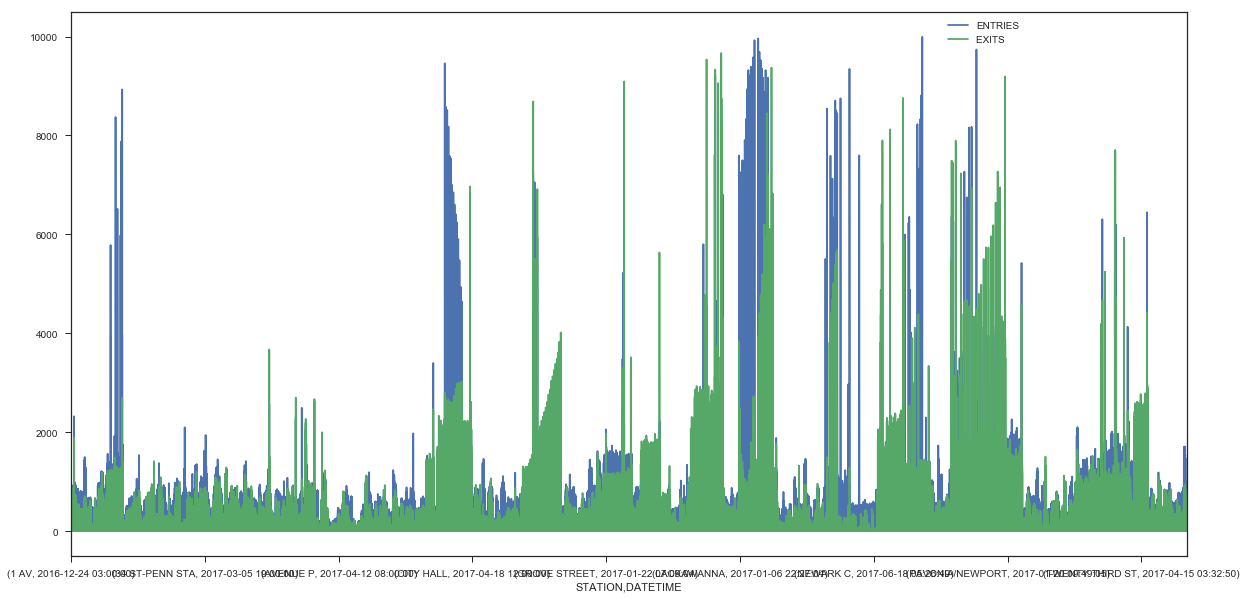

In [41]:
avg_station_time.plot(kind='line',
                      figsize=(20,10))

In [17]:
# avg_by_day = df.groupby('DATE').apply(np.mean)
# avg_by_time = df.groupby(pd.to_datetime(df['TIME'], format='%H:%M:%S')).apply(np.mean)
# avg_by_dtime = df.groupby(df['DATETIME']).apply(np.mean)

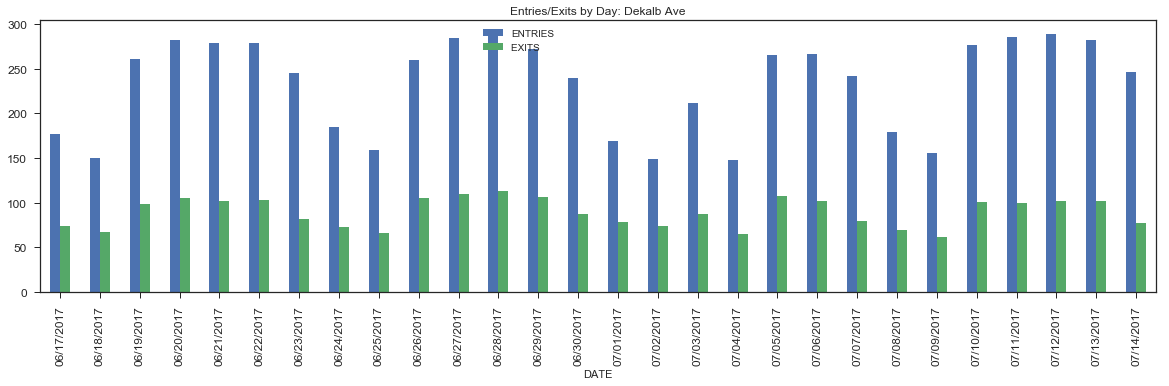

In [699]:
avg_by_day.plot(kind='bar',
                title='Entries/Exits by Day: Dekalb Ave',
                figsize=(20,5),
                fontsize=12)

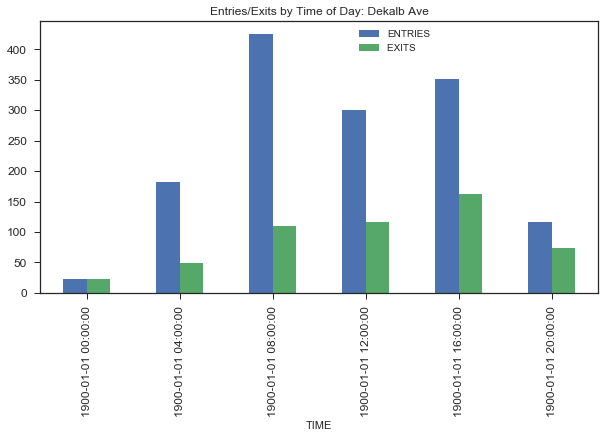

In [700]:
avg_by_time.plot(kind='bar',
                title='Entries/Exits by Time of Day: Dekalb Ave',
                figsize=(10,5),
                fontsize=12)

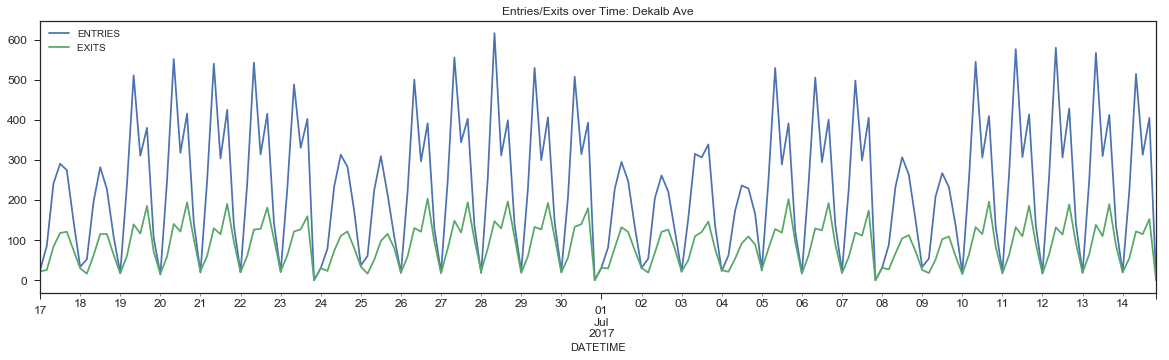

In [702]:
avg_by_dtime.plot(kind='line',
                title='Entries/Exits over Time: Dekalb Ave',
                figsize=(20,5),
                fontsize=12)